# 딥러닝을 사용한 추천 시스템

## Matrix Factorization MF 신경망으로 변환하기

In [2]:
# csv 파일에서 불러오기
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax


base_src = ''
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(u_data_src, sep='\t',
                      names=r_cols, encoding='latin-1')

ratings_train, ratings_test = train_test_split(
    ratings,
    test_size=0.2,
    shuffle=True,
    random_state=2022
)


In [3]:
K = 200

mu = ratings_train.rating.mean()

M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))
    

In [4]:
user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)

In [5]:
R = layers.dot([P_embedding, Q_embedding], axes=(2, 2))
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

In [6]:
result = model.fit(
    x = [ratings_train.user_id.values,
         ratings_train.movie_id.values],
    y = ratings_train.rating.values - mu,
    epochs = 60,
    batch_size = 256,
    validation_data = (
        [ratings_test.user_id.values,
            ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )
)

Epoch 1/60
313/313 [==============================] - 2s 4ms/step - loss: 5.2593 - RMSE: 1.1245 - val_loss: 5.0008 - val_RMSE: 1.1191
Epoch 2/60
313/313 [==============================] - 1s 4ms/step - loss: 4.7702 - RMSE: 1.1219 - val_loss: 4.5421 - val_RMSE: 1.1169
Epoch 3/60
313/313 [==============================] - 1s 4ms/step - loss: 4.3387 - RMSE: 1.1196 - val_loss: 4.1374 - val_RMSE: 1.1150
Epoch 4/60
313/313 [==============================] - 1s 4ms/step - loss: 3.9582 - RMSE: 1.1176 - val_loss: 3.7805 - val_RMSE: 1.1132
Epoch 5/60
313/313 [==============================] - 1s 4ms/step - loss: 3.6225 - RMSE: 1.1158 - val_loss: 3.4656 - val_RMSE: 1.1116
Epoch 6/60
313/313 [==============================] - 1s 4ms/step - loss: 3.3264 - RMSE: 1.1140 - val_loss: 3.1879 - val_RMSE: 1.1102
Epoch 7/60
313/313 [==============================] - 1s 4ms/step - loss: 3.0652 - RMSE: 1.1125 - val_loss: 2.9429 - val_RMSE: 1.1089
Epoch 8/60
313/313 [==============================] - 1s 3ms/s

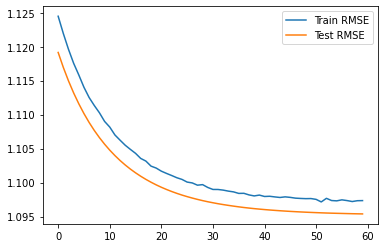

In [7]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()

In [27]:
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu

In [28]:
print(ratings_test[0:6])

       user_id  movie_id  rating  timestamp
59286      643       268       4  891450748
71695      470       319       3  879178216
70788      897       679       5  879991630
48299      545       199       4  880347770
16144      194       127       5  879520813
67827      814       665       4  885411204


In [29]:
print(predictions)

[[3.887971 ]
 [3.1385827]
 [3.3296113]
 [4.2722387]
 [3.7106202]
 [2.6601605]]


In [11]:
import numpy as np

def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [12]:
user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu

y_pred = np.ravel(y_pred, order='c')

y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.0974241033426295

# 딥러닝 방식 사용

In [36]:
# csv 파일에서 불러오기
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax


base_src = ''
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(u_data_src, sep='\t',
                      names=r_cols, encoding='latin-1')

ratings_train, ratings_test = train_test_split(
    ratings,
    test_size=0.2,
    shuffle=True,
    random_state=2022
)

def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# 잠재요인 수 2000으로 지정
K = 200

# 전체 평균 계산
mu = ratings_train.rating.mean()

# 사용자 아이디와 영화 아이디의 최대값을 구한다 
# +1를 더해주는 이유는 나중에 bias term 의 크기 1 추가를 고려한 것이다 
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1


#############################
# Keras Model
# 아래 부분은 앞에서와 동일하게 사용자와 아이템 데이터를 embedding을 통해 
# 각각 K개의 노드를 갖는 layer로 변환하고 
# 사용자 bias와 아이템 bias를 1개의 노드를 갖는 layer로 변환한다 

user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)

P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

R = Dense(2048)(R)
R = Activation('linear')(R)

R = Dense(1024)(R)
R = Activation('linear')(R)

R = Dense(256)(R)
R = Activation('linear')(R)

R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 1, 200)       188800      ['input_9[0][0]']                
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 200)       336600      ['input_10[0][0]']               
                                                                                            

In [37]:
# Model Fitting
# 모델 입력에 필요한 데이터 정리
train_user_ids = ratings_train.user_id.values
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values

test_user_ids = ratings_test.user_id.values
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values

result = model.fit(
    x = [train_user_ids, train_movie_ids],
    y = train_ratings - mu,
    epochs=50,
    batch_size = 512,
    validation_data=(
        [test_user_ids, test_movie_ids],
        test_ratings-mu
    )
)

Epoch 1/50
157/157 [==============================] - 5s 30ms/step - loss: 5.3885 - RMSE: 1.1242 - val_loss: 5.2514 - val_RMSE: 1.1179
Epoch 2/50
157/157 [==============================] - 5s 32ms/step - loss: 5.1266 - RMSE: 1.1222 - val_loss: 4.9987 - val_RMSE: 1.1166
Epoch 3/50
157/157 [==============================] - 5s 34ms/step - loss: 4.8807 - RMSE: 1.1191 - val_loss: 4.7586 - val_RMSE: 1.1124
Epoch 4/50
157/157 [==============================] - 6s 35ms/step - loss: 4.6493 - RMSE: 1.1171 - val_loss: 4.5345 - val_RMSE: 1.1099
Epoch 5/50
157/157 [==============================] - 6s 37ms/step - loss: 4.4319 - RMSE: 1.1141 - val_loss: 4.3242 - val_RMSE: 1.1077
Epoch 6/50
157/157 [==============================] - 6s 38ms/step - loss: 4.2270 - RMSE: 1.1112 - val_loss: 4.1252 - val_RMSE: 1.1039
Epoch 7/50
157/157 [==============================] - 8s 52ms/step - loss: 4.0340 - RMSE: 1.1071 - val_loss: 3.9386 - val_RMSE: 1.1006
Epoch 8/50
157/157 [==============================] - 7

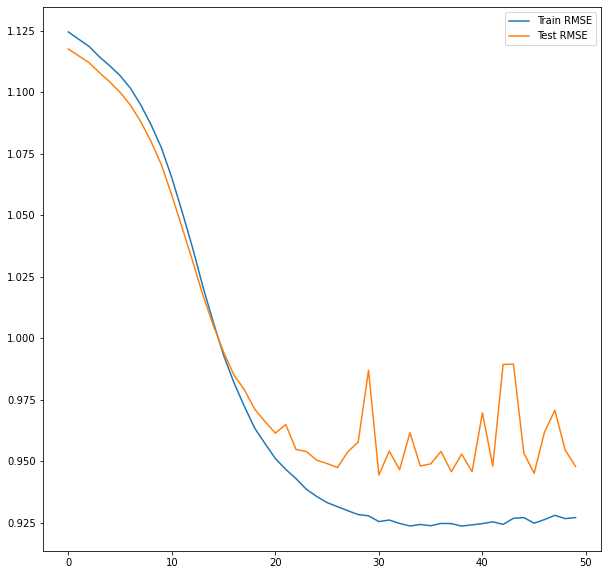

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()

In [31]:
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])
R = Dense(2048)(R)
R = Activation('relu')(R)

R = Dense(256)(R)
R = Activation('relu')(R)

R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       188800      ['input_3[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       336600      ['input_4[0][0]']                
                                                                                            

In [23]:
# Model Fitting
# 모델 입력에 필요한 데이터 정리
train_user_ids = ratings_train.user_id.values
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values

test_user_ids = ratings_test.user_id.values
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values

result = model.fit(
    x = [train_user_ids, train_movie_ids],
    y = train_ratings - mu,
    epochs=50,
    batch_size = 512,
    validation_data=(
        [test_user_ids, test_movie_ids],
        test_ratings-mu
    )
)

Epoch 1/50
157/157 [==============================] - 3s 19ms/step - loss: 1.1308 - RMSE: 1.1203 - val_loss: 1.1265 - val_RMSE: 1.1138
Epoch 2/50
157/157 [==============================] - 3s 18ms/step - loss: 1.1283 - RMSE: 1.1188 - val_loss: 1.1253 - val_RMSE: 1.1130
Epoch 3/50
157/157 [==============================] - 3s 18ms/step - loss: 1.1268 - RMSE: 1.1176 - val_loss: 1.1241 - val_RMSE: 1.1122
Epoch 4/50
157/157 [==============================] - 3s 18ms/step - loss: 1.1256 - RMSE: 1.1173 - val_loss: 1.1226 - val_RMSE: 1.1110
Epoch 5/50
157/157 [==============================] - 3s 19ms/step - loss: 1.1243 - RMSE: 1.1156 - val_loss: 1.1215 - val_RMSE: 1.1102
Epoch 6/50
157/157 [==============================] - 3s 18ms/step - loss: 1.1227 - RMSE: 1.1141 - val_loss: 1.1200 - val_RMSE: 1.1089
Epoch 7/50
157/157 [==============================] - 3s 21ms/step - loss: 1.1215 - RMSE: 1.1132 - val_loss: 1.1186 - val_RMSE: 1.1077
Epoch 8/50
157/157 [==============================] - 4

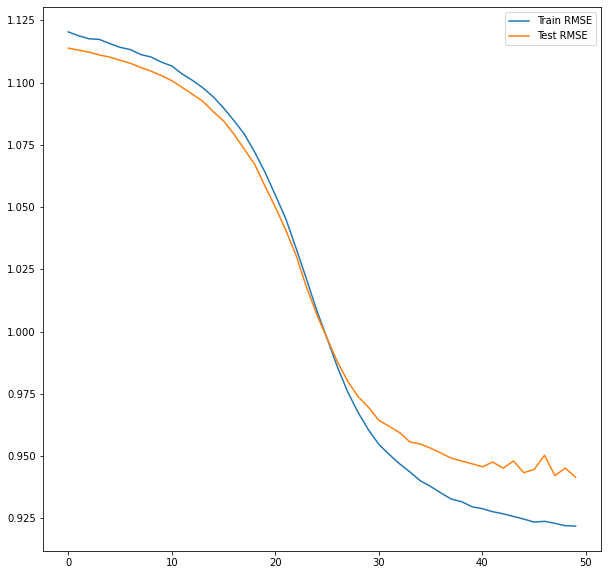

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()

### 딥러닝 모델에 변수 추가하기

In [ ]:
import os 
# csv 파일에서 불러오기
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax


base_src = ''
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(u_data_src, sep='\t',
                      names=r_cols, encoding='latin-1')

ratings_train, ratings_test = train_test_split(
    ratings,
    test_size=0.2,
    shuffle=True,
    random_state=2022
)


u_data_src = os.path.join(base_src, 'u.user')
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(u_data_src, sep='|',
                      names=u_cols, encoding='latin-1')

users = users[['user_id', 'occupation']]

occupation = dict()
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]
    
users['occupation'] = users['occupation'].apply(convert_occ)

L = len(occupation)

train_occ = pd.merge(ratings_train, users, on='user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on='user_id')['occupation']

K = 200
mu = ratings_train.rating.mean()

M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1


#############################
# Keras Model
# 아래 부분은 앞에서와 동일하게 사용자와 아이템 데이터를 embedding을 통해 
# 각각 K개의 노드를 갖는 layer로 변환하고 
# 사용자 bias와 아이템 bias를 1개의 노드를 갖는 layer로 변환한다 

user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)

P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

occ = Input(shape=(1,))
OCC_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)
OCC_layer = Flatten()(OCC_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, OCC_layer])
R = Dense(2048)(R)
R = Activation('linear')(R)

R = Dense(256)(R)
R = Activation('linear')(R)

R = Dense(1)(R)

model = Model(inputs=[user, item, occ], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_38 (Embedding)       (None, 1, 200)       188800      ['input_21[0][0]']               
                                                                                            

In [ ]:
# Model Fitting
# 모델 입력에 필요한 데이터 정리
train_user_ids = ratings_train.user_id.values
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values
train_occs = train_occ.values

test_user_ids = ratings_test.user_id.values
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values
test_occs = test_occ.values

result = model.fit(
    x = [train_user_ids, train_movie_ids, train_occs],
    y = train_ratings - mu,
    epochs= 65,
    batch_size = 512,
    validation_data=(
        [test_user_ids, test_movie_ids, test_occs],
        test_ratings-mu
    )
)

Epoch 1/65
157/157 [==============================] - 3s 17ms/step - loss: 5.3866 - RMSE: 1.1251 - val_loss: 5.2495 - val_RMSE: 1.1187
Epoch 2/65
157/157 [==============================] - 3s 17ms/step - loss: 5.1256 - RMSE: 1.1233 - val_loss: 4.9973 - val_RMSE: 1.1178
Epoch 3/65
157/157 [==============================] - 3s 17ms/step - loss: 4.8806 - RMSE: 1.1211 - val_loss: 4.7593 - val_RMSE: 1.1156
Epoch 4/65
157/157 [==============================] - 3s 18ms/step - loss: 4.6505 - RMSE: 1.1206 - val_loss: 4.5364 - val_RMSE: 1.1142
Epoch 5/65
157/157 [==============================] - 3s 18ms/step - loss: 4.4342 - RMSE: 1.1193 - val_loss: 4.3271 - val_RMSE: 1.1129
Epoch 6/65
157/157 [==============================] - 3s 18ms/step - loss: 4.2311 - RMSE: 1.1173 - val_loss: 4.1302 - val_RMSE: 1.1113
Epoch 7/65
157/157 [==============================] - 3s 19ms/step - loss: 4.0401 - RMSE: 1.1156 - val_loss: 3.9453 - val_RMSE: 1.1097
Epoch 8/65
157/157 [==============================] - 3

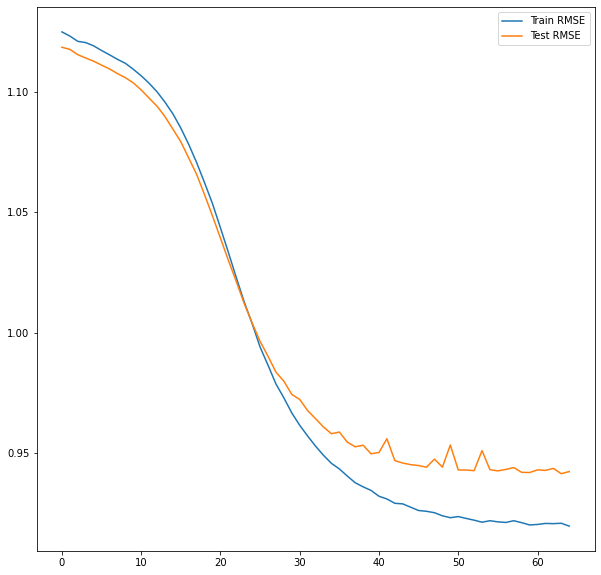

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()